## Changes in Precipitation and Discharge Trends in the Ammonnoosuc River Watershed, New Hampshire
Ryan Omslaer

Introduction:

As we see the effects of climate change continue to impact natural systems, it is important for us to understand shifting magnitudes and amounts of regional precipitation and discharge. Changes to these processes can have large impacts on existing and future infrastructure plans, potentially necessitating the strengthening or redesign of said infrastructure. One such area that may be greatly impacted by this is the Ammonoosuc River watershed in northern New Hampshire. With the head of the river beginning at Mount Washington, the location with the highest annual average precipitation in New England, this watershed provides a great example of a natural system that can be impacted greatly by increasing amounts of precipitation seen in short time frames.

Using this watershed as a case study, I will analyze this watershed for any trends in precipitation and discharge using discharge records from the Ammonoosuc Rivera t Bethlehem Junction (USGS 01137500), precipitation records from Jefferson, NH (USC00274329), and NOAA Physical Sciences Laboratory's gridded precipitation reanalysis (8kmx8km grid) centered on the Jefferson, NH rain gauge. Using this data, I will determine if there is an increase in daily large precipitation events on the watershed and the associated lag time between higher flows. Additionally, statistical tests will be run to determine if high precipitation events are increasing, the lag times associated with high precipitation events, and whether the lag times are increasing or decreasing. Furthermore, I will be comparing the results from the gauge and gridded precipitation values.

Study Site:

My study site is the Ammonoosuc River watershed in northwestern NH. The outlet of my watershed will be defined as the USGS 01137500 gauging station, located at Bethlehem Junction, NH (Figure 1).

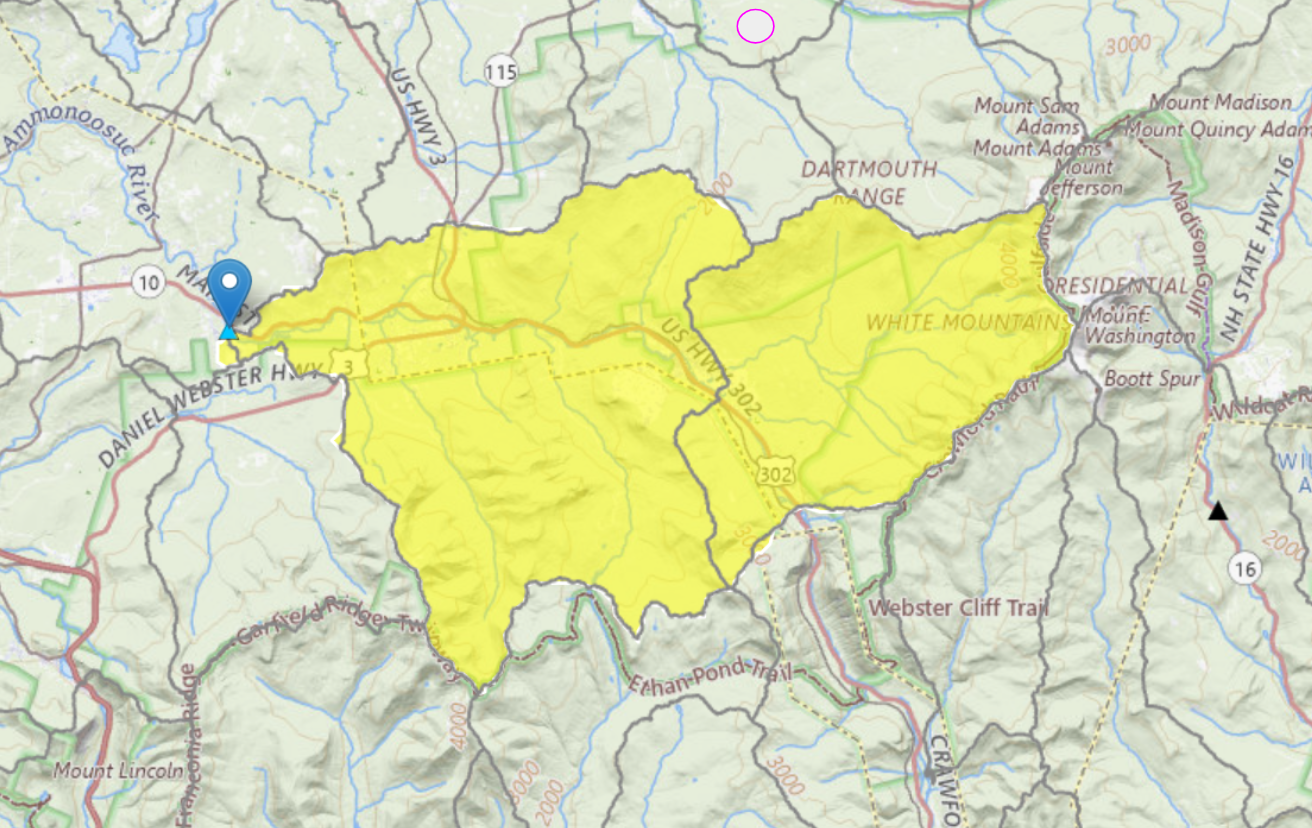
Figure 1: Depicts a map of the Ammonoosuc River watershed. Blue icon represents the watershed outlet and pink circle represents the precipitation gauge location.

Datasets:

Datasets I will be using are the USGS Ammonoosuc River at Bethlehem Junction daily discharge records, daily precipitation records from rain gauge USC00274329 located in Jefferson NH, and a gridded precipitation reanalysis by the NOAA Physical Sciences Laboratory. The gridded reanalysis will be centered on the rain gauge location in Jefferson, NH via lat and long.

GRID PRECIP IS 8KM BY 8KM GRID

Raw Data and Plotting Code:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import os
from pathlib import Path
from matplotlib.ticker import MaxNLocator, FuncFormatter
import pymannkendall as mk
from scipy.stats import wilcoxon
#import of libraries

In [2]:
qfile = 'discharge.txt'
grid_path = Path('Grid')
precip_files = ['4146341.csv', '4151138.csv', '4151152.csv']
#all input files needed

In [3]:
lat = 44.4169 #latitude of Jefferson, NH
lon = 288.4992 #longitude in 0-360 format
files = sorted(glob.glob(os.path.join(grid_path, "precip.V1.0.*.nc"))) 
dfs = []
for f in files:
    ds = xr.open_dataset(f) #opens each .nc file
    precip = ds['precip']
    series = precip.sel(lat=lat, lon=lon, method='nearest') #extracts data from cell closest to Jefferson, NH
    df = series.to_dataframe().reset_index() #converts data to df format
    dfs.append(df) #each year/file is appended to a list
    ds.close()  # free memory
grid_all = pd.concat(dfs, ignore_index=True) #concatenation of each year into single df
grid_all = grid_all.drop(columns=['lat', 'lon'])
grid_all = grid_all.rename(columns={'time': 'Date'})
grid_all['Date'] = pd.to_datetime(grid_all['Date'])
grid_all = grid_all.set_index('Date')
grid_all['Grid Precip (in)'] = grid_all['precip'] / 25.4
grid_all = grid_all.drop(columns=['precip'])

In [4]:
ammo = pd.read_csv(qfile, comment='#', sep='\s+') #inports data and removes headers
ammo = ammo.drop(columns=['agency_cd', 'site_no', '64501_00060_00003_cd'])
ammo = ammo.rename(columns={'64501_00060_00003': 'Discharge (cfs)'})
ammo = ammo.rename(columns={'datetime': 'Date'})
#dropping unnecessary columns, renaming columns for clarity
ammo = ammo[ammo['Date'].str.match(r'\d{4}-\d{2}-\d{2}')] #formatting for datetime
ammo['Date'] = pd.to_datetime(ammo['Date'])
ammo = ammo.set_index('Date')
ammo['Discharge (cfs)'] = pd.to_numeric(ammo['Discharge (cfs)'], errors='coerce')


In [5]:
precip_dfs = []
for f in precip_files: #loops through all precip files
    df = pd.read_csv(f)
    df = df.rename(columns={'DATE': 'Date'})
    if 'MDPR' in df.columns: #adds MDPR totals to precip if it is present
        df['MDPR'] = df['MDPR'].fillna(0)
        df['PRCP'] = df['PRCP'] + df['MDPR']
        df = df.rename(columns={'PRCP': 'Gauge Precip (in)'})
        df = df.drop(columns=['STATION', 'NAME', 'DAPR', 'DASF', 'MDSF', 'SNOW', 'SNWD', 'MDPR'], errors='ignore') #dropping unnecessary columns
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        precip_dfs.append(df) #appends all dfs to precip_dfs
precip_all = pd.concat(precip_dfs) #puts all files under the same df
precip_all = precip_all.sort_index()

In [6]:
starts = [df.index.min() for df in [precip_all, grid_all, ammo]]
ends   = [df.index.max() for df in [precip_all, grid_all, ammo]]
start = max(starts)
end   = min(ends)
print(f"Overlapping period: {start.date()} to {end.date()}")
#finding the beginning and end of overlapping period of records

Overlapping period: 1963-10-01 to 2015-12-31


In [7]:
if isinstance(grid_all, xr.DataArray):
    grid_all = grid_all.to_series().to_frame(name='Grid Precip (in)')
precip_trimmed = precip_all.loc[start:end]
grid_all_trimmed = grid_all.loc[start:end]
ammo_trimmed = ammo.loc[start:end]
project = pd.concat([precip_trimmed, grid_all_trimmed, ammo_trimmed], axis=1, join='outer')
#combining all data into one df based on overlapping period

In [8]:
project = project.copy()
project['water_year'] = project.index.to_series().apply(lambda d: d.year + 1 if d.month >= 10 else d.year)
cols_of_interest = ['Gauge Precip (in)', 'Grid Precip (in)', 'Discharge (cfs)']
project_nonan = project.dropna(subset=cols_of_interest)
days_per_year_complete = project_nonan.groupby('water_year').size()
complete_years = days_per_year_complete[days_per_year_complete >= 365].index
project_complete = project_nonan[project_nonan['water_year'].isin(complete_years)].copy()
print(f"Filtered data length: {len(project_complete)} days")
#filtering data to only include complete water years

Filtered data length: 12053 days


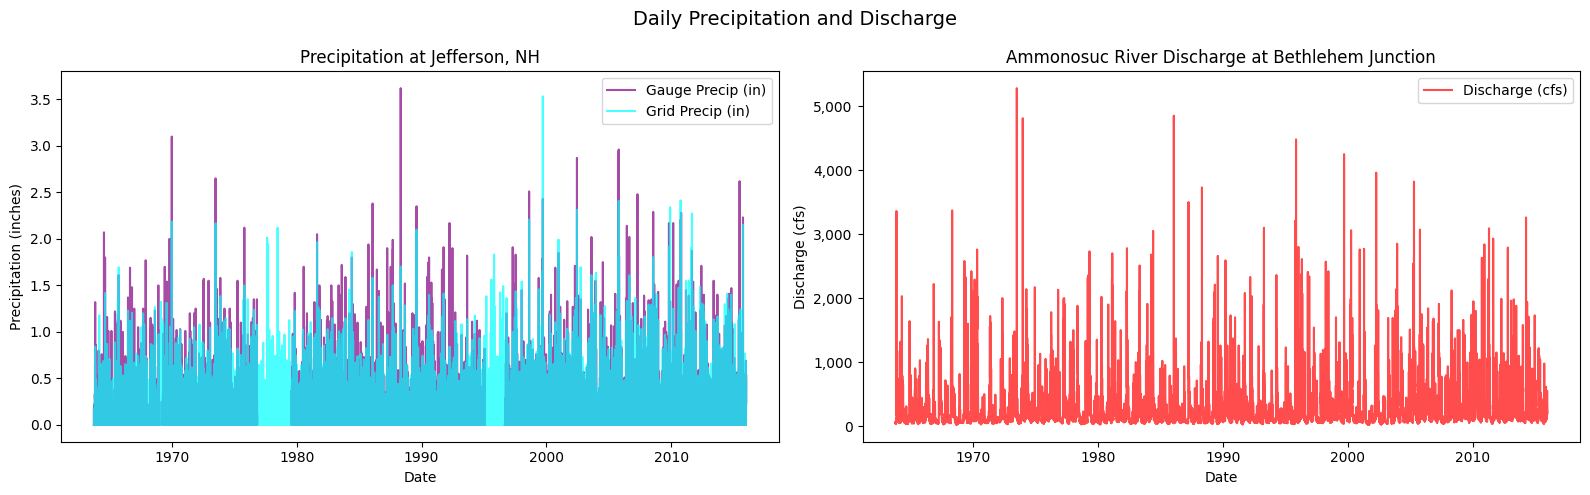

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16,5), sharey=False)
# --- Left: Precipitation only ---
axes[0].plot(project.index, project['Gauge Precip (in)'], 
             label='Gauge Precip (in)', color='purple', alpha=0.7)
axes[0].plot(project.index, project['Grid Precip (in)'], 
             label='Grid Precip (in)', color='cyan', alpha=0.7)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Precipitation (inches)')
axes[0].set_title('Precipitation at Jefferson, NH')
axes[0].legend()
# --- Right: Discharge only ---
axes[1].plot(project.index, project['Discharge (cfs)'], 
             label='Discharge (cfs)', color='red', alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Discharge (cfs)')
axes[1].set_title('Ammonosuc River Discharge at Bethlehem Junction')
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=6))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
axes[1].legend()
fig.suptitle("Daily Precipitation and Discharge", fontsize=14)
plt.tight_layout()
plt.show()


In [10]:
pgrid = project_complete['Grid Precip (in)'].dropna()
pgrid_nonzero = pgrid[pgrid > 0]
pgauge = project_complete['Gauge Precip (in)'].dropna()
pgauge_nonzero = pgauge[pgauge > 0]

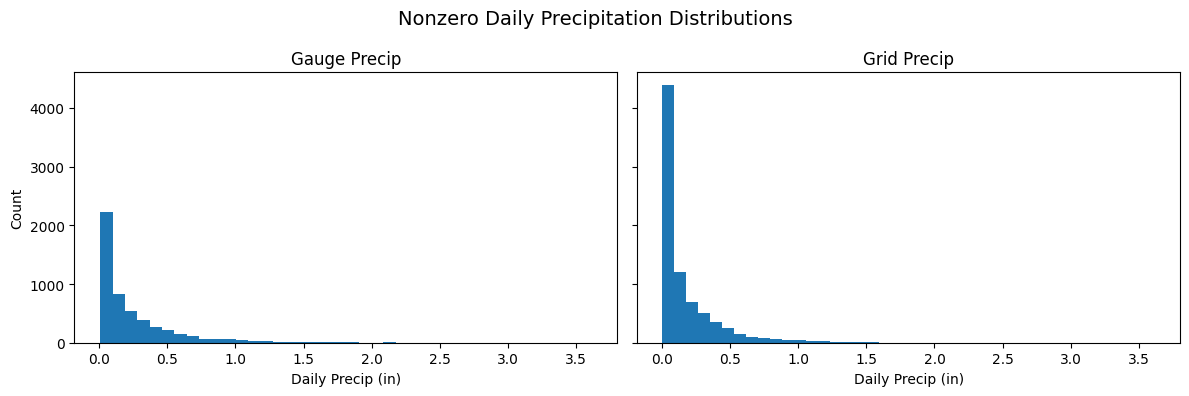

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)
axes[0].hist(pgauge_nonzero, bins=40)
axes[0].set_title("Gauge Precip")
axes[0].set_xlabel("Daily Precip (in)")
axes[0].set_ylabel("Count")
axes[1].hist(pgrid_nonzero, bins=40)
axes[1].set_title("Grid Precip")
axes[1].set_xlabel("Daily Precip (in)")
fig.suptitle("Nonzero Daily Precipitation Distributions", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\ryano\AppData\Local\Temp\ipykernel_53208\3471289393.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([pgauge_nonzero, pgrid_nonzero],
C:\Users\ryano\AppData\Local\Temp\ipykernel_53208\3471289393.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2-1].boxplot([pgauge_90, pgrid_90],


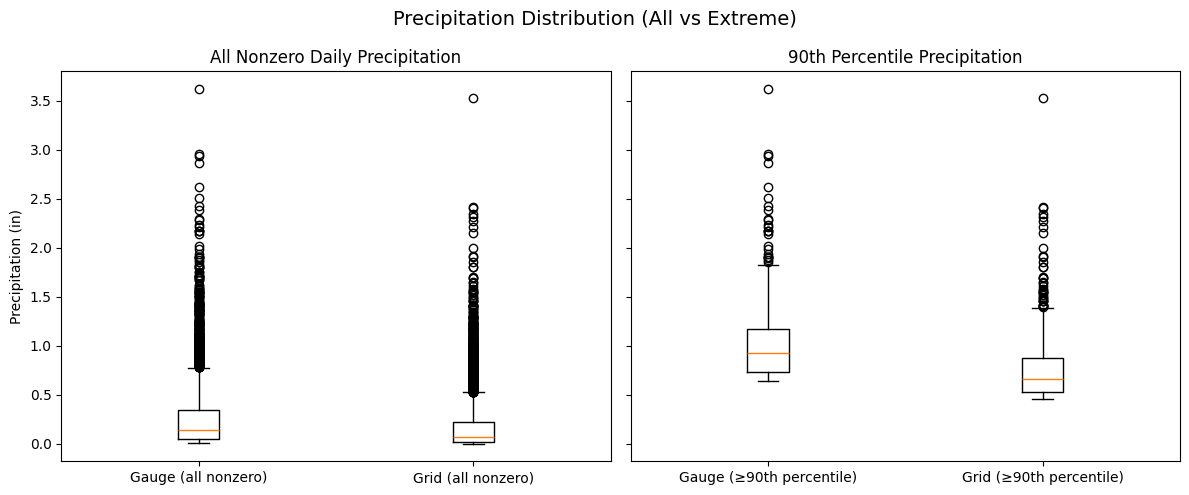

Gauge 90th percentile threshold: 0.64 in
Grid  90th percentile threshold: 0.453 in
Gauge ≥90th sample size: 517
Grid ≥90th sample size: 798


In [12]:
# ---- Base precipitation data (nonzero) ----
pgauge = project_complete['Gauge Precip (in)'].dropna()
pgauge_nonzero = pgauge[pgauge > 0]

pgrid = project_complete['Grid Precip (in)'].dropna()
pgrid_nonzero = pgrid[pgrid > 0]

# ---- 90th percentile thresholds ----
gauge_thresh = pgauge_nonzero.quantile(0.90)
grid_thresh  = pgrid_nonzero.quantile(0.90)

# ---- Filtered (only >= 90th percentile) ----
pgauge_90 = pgauge_nonzero[pgauge_nonzero >= gauge_thresh]
pgrid_90  = pgrid_nonzero[pgrid_nonzero >= grid_thresh]

# ---- Combined boxplots ----
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Panel 1: All nonzero precip
axes[0].boxplot([pgauge_nonzero, pgrid_nonzero],
                labels=['Gauge (all nonzero)', 'Grid (all nonzero)'])
axes[0].set_title("All Nonzero Daily Precipitation")
axes[0].set_ylabel("Precipitation (in)")

# Panel 2: Only 90th percentile events
axes[2-1].boxplot([pgauge_90, pgrid_90],
                  labels=['Gauge (≥90th percentile)', 'Grid (≥90th percentile)'])
axes[2-1].set_title("90th Percentile Precipitation")

fig.suptitle("Precipitation Distribution (All vs Extreme)", fontsize=14)
plt.tight_layout()
plt.show()

print("Gauge 90th percentile threshold:", round(gauge_thresh, 3), "in")
print("Grid  90th percentile threshold:", round(grid_thresh, 3), "in")
print("Gauge ≥90th sample size:", len(pgauge_90))
print("Grid ≥90th sample size:", len(pgrid_90))


In [13]:
def find_events_and_lags(df, precip_col='Gauge Precip (in)', q=0.9, min_gap_days=10, window_days=10, require_single_day=True):
    """
    df: DataFrame with precip and discharge columns indexed by Date
    q: percentile for threshold (e.g., 0.9)
    min_gap_days: minimum days between independent events
    window_days: days after event to search for discharge peak
    require_single_day: if True, skip events where the window contains multiple days >= threshold
    returns: DataFrame of events with lag statistics
    """
    working = df[[precip_col, 'Discharge (cfs)']].dropna()
    threshold = working[working[precip_col] > 0][precip_col].quantile(q)
    event_starts = []
    skip_until = None
    for date, rain in working[precip_col].items():
        if skip_until is not None and date <= skip_until:
            continue
        if rain >= threshold:
            event_starts.append(date)
            skip_until = date + pd.Timedelta(days=min_gap_days)
    events = []
    for start in event_starts:
        end = start + pd.Timedelta(days=window_days)
        window = working.loc[start:end]
        if window.empty:
            continue
        n_sig = (window[precip_col] >= threshold).sum()
        if require_single_day and n_sig > 1:
            continue
        peak_date = window['Discharge (cfs)'].idxmax()
        lag_days = (peak_date - start).days
        peak_q = window.loc[peak_date, 'Discharge (cfs)']
        events.append({
            'event_date': start,
            'peak_date': peak_date,
            'lag_days': lag_days,
            'peak_discharge': peak_q,
            'rain_amount': working.loc[start, precip_col],
            'n_sig_days_in_window': n_sig
        })
    events_df = pd.DataFrame(events)
    return events_df, threshold

90th percentile threshold (Gauge-based): 0.64 in
Filtered to 217 clean single-storm events.

    event_date  lag_days  rain_amount  peak_discharge
0   1964-10-21         7         1.16           166.0
1   1965-02-25         9         1.01            90.0
2   1965-06-22         2         0.78           267.0
3   1965-08-10         0         1.08           213.0
4   1965-09-25         0         1.61          1030.0
..         ...       ...          ...             ...
212 2015-01-19         0         0.72           716.0
213 2015-08-12         0         0.99           274.0
214 2015-08-26         0         0.75            80.5
215 2015-09-15         0         0.79           103.0
216 2015-09-30         0         2.23           978.0

[217 rows x 4 columns]

Lag time summary:
count    217.000000
mean       1.760369
std        2.829687
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max       10.000000
Name: lag_days, dtype: float64

90th percentile threshol

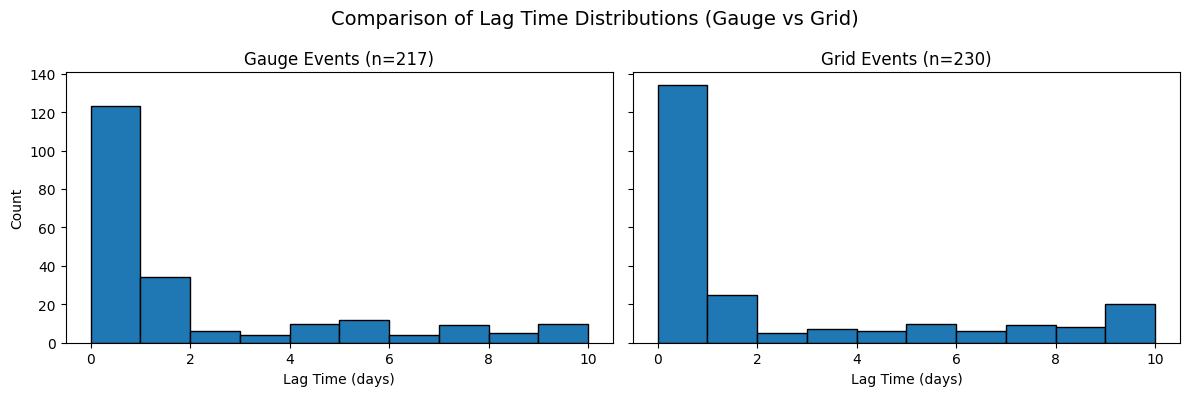


Lag times by season (Gauge-based):
        count      mean       std  min  25%  50%  75%   max
season                                                     
Winter   31.0  2.838710  3.541156  0.0  0.0  1.0  5.0  10.0
Spring   55.0  2.600000  3.297586  0.0  0.0  1.0  5.0  10.0
Summer   64.0  1.250000  2.145501  0.0  0.0  0.0  1.0   9.0
Fall     67.0  1.059701  2.308618  0.0  0.0  0.0  1.0  10.0


C:\Users\ryano\AppData\Local\Temp\ipykernel_53208\365487239.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(events_df.groupby('season')['lag_days'].describe())


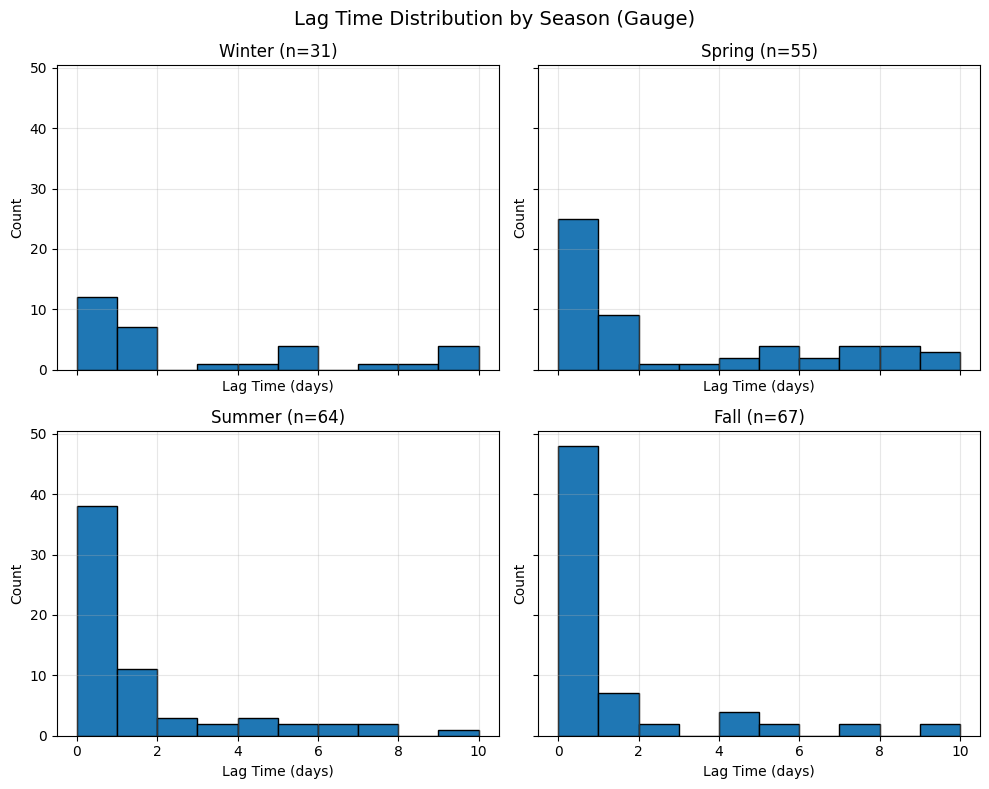

In [14]:
events_df, threshold = find_events_and_lags(project_complete, q=0.9, 
                                            min_gap_days=10, window_days=10, 
                                            require_single_day=True)

print(f"90th percentile threshold (Gauge-based): {threshold:.2f} in")
print(f"Filtered to {len(events_df)} clean single-storm events.\n")

if not events_df.empty:
    print(events_df[['event_date', 'lag_days', 'rain_amount', 'peak_discharge']])
    print("\nLag time summary:")
    print(events_df['lag_days'].describe())

    # ----------------------------
    # 2. Grid-based events for lag comparison
    # ----------------------------
    events_df_grid, threshold_grid = find_events_and_lags(
        project_complete, q=0.9,
        min_gap_days=10, window_days=10,
        require_single_day=True,
        precip_col='Grid Precip (in)'  # override
    )

    print(f"\n90th percentile threshold (Grid-based): {threshold_grid:.2f} in")
    print(f"Filtered to {len(events_df_grid)} grid-based events.")

    # ----------------------------
    # 3. Side-by-side histograms: Gauge vs Grid
    # ----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

    axes[0].hist(events_df['lag_days'], bins=range(0, 11), edgecolor='black')
    axes[0].set_title(f'Gauge Events (n={len(events_df)})')
    axes[0].set_xlabel('Lag Time (days)')
    axes[0].set_ylabel('Count')

    axes[1].hist(events_df_grid['lag_days'], bins=range(0, 11), edgecolor='black')
    axes[1].set_title(f'Grid Events (n={len(events_df_grid)})')
    axes[1].set_xlabel('Lag Time (days)')

    fig.suptitle("Comparison of Lag Time Distributions (Gauge vs Grid)", fontsize=14)
    plt.tight_layout()
    plt.show()

    events_df = events_df.copy()
    events_df['month'] = events_df['event_date'].dt.month
    events_df['season'] = pd.cut(
        events_df['month'], bins=[0, 3, 6, 9, 12],
        labels=['Winter', 'Spring', 'Summer', 'Fall'],
        include_lowest=True, right=False
    )
    events_df.loc[events_df['month'].isin([12, 1, 2]), 'season'] = 'Winter'

    print("\nLag times by season (Gauge-based):")
    print(events_df.groupby('season')['lag_days'].describe())

    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    axes = axes.flatten()
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    bins = range(0, 11)

    for ax, season in zip(axes, seasons):
        subset = events_df[events_df['season'] == season]['lag_days']
        ax.hist(subset, bins=bins, edgecolor='black')
        ax.set_title(f'{season} (n={len(subset)})')
        ax.set_xlabel('Lag Time (days)')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)

    fig.suptitle('Lag Time Distribution by Season (Gauge)', fontsize=14)
    plt.tight_layout()
    plt.show()

else:
    print("No events found after filtering.")


In [15]:
#Mann-Kendall Trend Test Precipitation Analysis
series = project_complete['Gauge Precip (in)'].resample('YE').sum()
result = mk.original_test(series)
print(result)

Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(1.2854861790367877e-05), z=np.float64(4.362561186326186), Tau=np.float64(0.4155354449472097), s=np.float64(551.0), var_s=np.float64(15894.333333333334), slope=np.float64(0.5355357142857142), intercept=np.float64(18.073839285714286))


In [16]:
# Mann-Kendall Trend Test Precipitation Analysis Grid
series2 = project_complete['Grid Precip (in)'].resample('YE').sum()
result2 = mk.original_test(series2)
print(result2)

Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(2.1233006915810648e-05), z=np.float64(4.251514174310611), Tau=np.float64(0.40497737556561086), s=np.float64(537.0), var_s=np.float64(15894.333333333334), slope=np.float64(0.5099307004507485), intercept=np.float64(18.248441790605522))


In [17]:
#Mann-Kendall Trend Test Lag Time Analysis
lag_series = events_df.set_index('event_date')['lag_days']
result3 = mk.original_test(lag_series)
print(result3)

Mann_Kendall_Test(trend='decreasing', h=np.True_, p=np.float64(0.021309089383470647), z=np.float64(-2.3024627568849825), Tau=np.float64(-0.09472606246799795), s=np.float64(-2220.0), var_s=np.float64(928815.3333333334), slope=np.float64(0.0), intercept=np.float64(0.0))


In [18]:
#Stat test for difference between gauge and grid precip
df = project_complete.dropna(subset=['Gauge Precip (in)', 'Grid Precip (in)'])
# daily difference
df['diff'] = df['Gauge Precip (in)'] - df['Grid Precip (in)']
# run Wilcoxon on the paired differences
stat, pval = wilcoxon(df['diff'])
print(f"Wilcoxon stat: {stat}")
print("Exact p-value:", "{:.3e}".format(pval))
print(df['diff'].describe())
print("Median difference:", df['diff'].median())
print("Mean difference:", df['diff'].mean())
#Shows median difference between gauge and grid precip is -.002

Wilcoxon stat: 13765197.0
Exact p-value: 3.000e-33
count    12053.000000
mean        -0.002717
std          0.133895
min         -1.411110
25%         -0.017727
50%          0.000000
75%          0.000000
max          1.917898
Name: diff, dtype: float64
Median difference: 0.0
Mean difference: -0.0027165412306476714


In [19]:
project_complete['diff'] = project_complete['Gauge Precip (in)'] - project_complete['Grid Precip (in)']
project_complete['diff'].median()
project_complete

,Gauge Precip (in),Grid Precip (in),Discharge (cfs),water_year,diff
Date,,,,,
1964-10-01,0.00,0.000000,39.0,1965,0.000000
1964-10-02,0.00,0.000000,38.0,1965,0.000000
1964-10-03,0.36,0.315767,62.0,1965,0.044233
1964-10-04,0.00,0.000000,60.0,1965,0.000000
1964-10-05,0.00,0.000000,46.0,1965,0.000000
...,...,...,...,...,...
2015-09-26,0.00,0.000000,37.3,2015,0.000000
2015-09-27,0.00,0.000000,36.7,2015,0.000000
2015-09-28,0.00,0.000000,36.4,2015,0.000000


In [20]:
df_thresh = df[(df["Grid Precip (in)"] > 0.45) & (df["Gauge Precip (in)"] > 0.45)]
len(df_thresh)

586

In [21]:
df_thresh["diff"] = df_thresh["Grid Precip (in)"] - df_thresh["Gauge Precip (in)"]
stat, p = wilcoxon(df_thresh["Grid Precip (in)"], df_thresh["Gauge Precip (in)"])
print("Wilcoxon stat:", stat)
print("Exact p-value:", f"{p:.3e}")

Wilcoxon stat: 48761.0
Exact p-value: 1.076e-19


C:\Users\ryano\AppData\Local\Temp\ipykernel_53208\1063522089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_thresh["diff"] = df_thresh["Grid Precip (in)"] - df_thresh["Gauge Precip (in)"]


Finding the associated lag time between large precipitation events and associated higher flows at the watershed outlet. Additionally running a statistical test finding what a "large" precip event is.

Recurrence Interval/Exceedance Probability calcs/plot of both gauge precipitation, grid precipitation, and discharge.

Statistical test of if the difference between the reanalysis and gauge data are statistically signifcant. Ie can we trust the reanalysis data.

Statistical analysis of if the precipitation or discharge is increasing over time.

Discussion/Conclusion:

What is the lag time between events?

Is there a difference between both types of precipitation data? There does appear to be variation looking at the raw data.

What is the result of the test analyzing increasing trends in precip/discharge over time.